In [310]:
import pickle
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

from vit_pytorch import ViT

## MyoArmband Dataset

In [5]:
train_path = 'datasets/MyoArmbandDataset/PreTrainingDataset/'
train_candidates = 12
eval_path = 'datasets/MyoArmbandDataset/EvaluationDataset/'
eval_candidates = 15

In [411]:
def get_raw_dataset(eval_path):
    person_folders = os.listdir(eval_path)

    first_folder = os.listdir(eval_path)[0]
    keys = next(os.walk((eval_path+first_folder)))[1]

    number_of_classes = 7
    number_of_vector_per_example = 200
    size_non_overlap = 50

    raw_dataset_dict = {}
    for key in keys:
            
        raw_dataset = {
            'examples': [],
            'labels': [],
        }
        list_dataset = []
        list_labels = []
        for person_dir in person_folders:
            examples = []
            labels = []
            data_path = eval_path + person_dir + '/' + key
            for data_file in os.listdir(data_path):
                if (data_file.endswith(".dat")):
                    data_read_from_file = np.fromfile((data_path+'/'+data_file), dtype=np.int16)
                    data_read_from_file = np.array(data_read_from_file, dtype=np.float32)

                    dataset_example_formatted = []
                    example = []
                    emg_vector = []
                    for value in data_read_from_file:
                        emg_vector.append(value)
                        if (len(emg_vector) >= 8):
                            if (example == []):
                                example = emg_vector
                            else:
                                example = np.row_stack((example, emg_vector))
                            emg_vector = []
                            if (len(example) >= number_of_vector_per_example):
                                example = example.transpose()
                                dataset_example_formatted.append(example)
                                example = example.transpose()
                                example = example[size_non_overlap:]
                    dataset_example_formatted = np.array(dataset_example_formatted)
                    examples.append(dataset_example_formatted)
                    data_file_index = int(data_file.split('classe_')[1][:-4])
                    label = data_file_index % number_of_classes + np.zeros(dataset_example_formatted.shape[0])
                    labels.append(label)

            raw_dataset['examples'].append(np.concatenate(examples))
            raw_dataset['labels'].append(np.concatenate(labels))

        raw_dataset_dict[key] = raw_dataset

    return raw_dataset_dict

In [551]:
eval_raw_dataset_dict = get_raw_dataset(eval_path)
train_raw_dataset_dict = get_raw_dataset(train_path)

/var/folders/k8/_qw1v4gj2cv9cqh75_yrt3pc0000gn/T/ipykernel_31040/548029492.py:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if (example == []):


In [561]:
mad_all_windows = eval_raw_dataset_dict['training0']['examples'] + \
                    eval_raw_dataset_dict['Test0']['examples'] + \
                    eval_raw_dataset_dict['Test1']['examples'] + \
                    train_raw_dataset_dict['training0']['examples']

mad_all_labels = eval_raw_dataset_dict['training0']['labels'] + \
                    eval_raw_dataset_dict['Test0']['labels'] + \
                    eval_raw_dataset_dict['Test1']['labels'] + \
                    train_raw_dataset_dict['training0']['labels']

In [562]:
# filter by labels
mad_windows = None
mad_lables = None
for mad_p_examples, mad_p_labels in zip(mad_all_windows, mad_all_labels):
    label_map = (mad_p_labels >= 0) & (mad_p_labels <= 4)
    mad_subject_windows = mad_p_examples[label_map]
    subject_labels = mad_p_labels[label_map]


    if mad_windows is None:
        mad_windows = mad_subject_windows
        mad_lables = subject_labels
    else:
        mad_windows = np.concatenate((mad_windows, mad_subject_windows))
        mad_lables = np.concatenate((mad_lables, subject_labels))

In [563]:
mad_windows.shape

(24729, 8, 200)

## Nina Pro DB5

In [564]:
emg_min = -128.
emg_max = 127.

sampling_rate = 200 # Hz
window_length = sampling_rate # 1 second
overlap = 50
stride = window_length - overlap

In [565]:
def create_window_dataset(X, y, desired_labels = None):
    features_dataset = {key: [] for key in np.unique(y)}
    last_class_idx = None
    consequetive_features = []

    for class_idx, feature in zip(y, X):
        if class_idx != last_class_idx:
            if consequetive_features:
                features_dataset[class_idx].append(np.array(consequetive_features))
            consequetive_features = [feature]
            last_class_idx = class_idx
        else:
            consequetive_features.append(feature)

    if consequetive_features:
        features_dataset[class_idx].append(np.array(consequetive_features))

    windows = []
    labels = []
    for class_idx, feature_list in features_dataset.items():
        if desired_labels is None or class_idx in desired_labels:
            for consequetive_features in feature_list:
                num_windows = (consequetive_features.shape[0] - window_length) // stride + 1
                for i in range(num_windows):
                    start = i * stride
                    end = start + window_length
                    window = consequetive_features[start:end, :]
                    windows.append(window)
                    labels.append(class_idx)

    return np.array(windows, dtype=np.float32), np.array(labels, dtype=int)

In [566]:
ninapro_windows = None
ninapro_lables = None

ninapro_base_dir = 'datasets/NinaProDB5/'
ninapro_person_dirs = next(os.walk(ninapro_base_dir))[1]
for nina_person_dir in ninapro_person_dirs:
    subject_id = nina_person_dir[-1]
    files = os.listdir(ninapro_base_dir + nina_person_dir)
    for file in files:
        if file.endswith('E2_A1.mat'):
            print(file)
            filepath = ninapro_base_dir + nina_person_dir + '/' + file

            ninapro_s1 = loadmat(filepath)

            ninapro_s_x_raw = ninapro_s1['emg'][:, :8]
            ninapro_s_x = np.interp(ninapro_s_x_raw, (emg_min, emg_max), (-1, +1))
            ninapro_s_y = ninapro_s1['restimulus'].squeeze()

            subject_windows, subject_labels = create_window_dataset(X = ninapro_s_x, y = ninapro_s_y, desired_labels = [0,13,14,15,16])

            if ninapro_windows is None:
                ninapro_windows = subject_windows
                ninapro_lables = subject_labels
            else:
                ninapro_windows = np.concatenate((ninapro_windows, subject_windows))
                ninapro_lables = np.concatenate((ninapro_lables, subject_labels))

ninapro_windows = ninapro_windows.swapaxes(1,2)

# replace labels
label_map = {0: 0,
             13: 2,
             14: 4,
             15: 1,
             16: 3,
             }

ninapro_mapped_labels = np.vectorize(label_map.get)(ninapro_lables)


S5_E2_A1.mat
S2_E2_A1.mat
S3_E2_A1.mat
S4_E2_A1.mat
S10_E2_A1.mat
S8_E2_A1.mat
S1_E2_A1.mat
S6_E2_A1.mat
S7_E2_A1.mat
S9_E2_A1.mat


## Build dataloader

In [567]:
ninapro_windows.shape, ninapro_mapped_labels.shape

((5978, 8, 200), (5978,))

In [568]:
mad_windows.shape, mad_lables.shape

((24729, 8, 200), (24729,))

In [575]:
# combine mad and ninapro data
windows = np.concatenate((mad_windows, ninapro_windows))
labels = np.concatenate((mad_lables, ninapro_mapped_labels))
n_labels = len(np.unique(labels))
windows.shape, labels.shape

((30707, 8, 200), (30707,))

In [570]:
train_x, test_x, train_y, test_y = train_test_split(windows, labels)

In [571]:
class CustomEMGDataset(Dataset):
    def __init__(self, x_samples, y_samples):
        self.x_samples = x_samples
        self.y_samples = y_samples

    def __len__(self):
        return len(self.x_samples)
    
    def __getitem__(self, idx):
        x_tensor = torch.tensor(self.x_samples[idx,:,:])
        y_tensor = torch.tensor(self.y_samples[idx]).type(torch.LongTensor)
        return x_tensor, y_tensor

In [572]:
train_dataset = CustomEMGDataset(train_x, train_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomEMGDataset(test_x, test_y)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [573]:
x, y = next(iter(test_dataloader))

<AxesSubplot:>

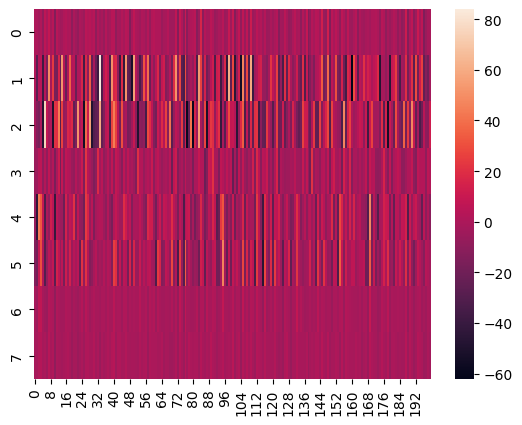

In [574]:
sns.heatmap(x[0,:,:])

## Train model

In [538]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.flatten = nn.Flatten(start_dim=1)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        x = self.flatten(x)
        out = self.linear_relu_stack(x)
        return out

In [576]:
train_features, train_labels = next(iter(train_dataloader))

In [577]:
device = 'mps'

In [578]:
model = FFNN(200*8, 128, n_labels).to(device)

In [579]:
model(train_features.to(device)).shape

torch.Size([32, 5])

In [582]:
model = ViT(
    image_size = 200,
    patch_size = 8,
    num_classes = n_labels,
    dim = 64,
    depth = 1,
    heads = 2,
    mlp_dim = 128,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels=1,
).to(device) 

img = torch.randn(10, 1, 8, 200).to(device)

preds = model(img)

In [583]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [586]:
history = {
    'accs': [],
    'losses': [],
}

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        model.train()

        train_inputs, train_labels = data
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        if model.__class__.__name__ == 'ViT':
            train_inputs.unsqueeze_(axis=1)

        optimizer.zero_grad()

        outputs = model(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        history['losses'].append(loss.item())
        if i % 1000 == 999:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.8f}')
            running_loss = 0.0

    accs = []
    for data in test_dataloader:
        test_inputs, test_labels = data
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        if model.__class__.__name__ == 'ViT':
            test_inputs.unsqueeze_(axis=1)
        model.eval()
        with torch.no_grad():
            outputs = model(test_inputs)
            predicted_labels = outputs.cpu().max(dim=1).indices

        test_labels = test_labels.cpu()
        acc = accuracy_score(test_labels, predicted_labels)
        accs.append(acc)

    history['accs'].append( np.mean(accs))
    print('test accuracy', np.mean(accs))

print('Finished Training')

test accuracy 0.7636179956896552
test accuracy 0.7675871048850574
test accuracy 0.7798670977011495
test accuracy 0.7714439655172414
test accuracy 0.7850484913793103
test accuracy 0.7817304238505748
test accuracy 0.7879265445402299
test accuracy 0.7914825790229885
test accuracy 0.7874057112068965
test accuracy 0.7759473778735633
Finished Training


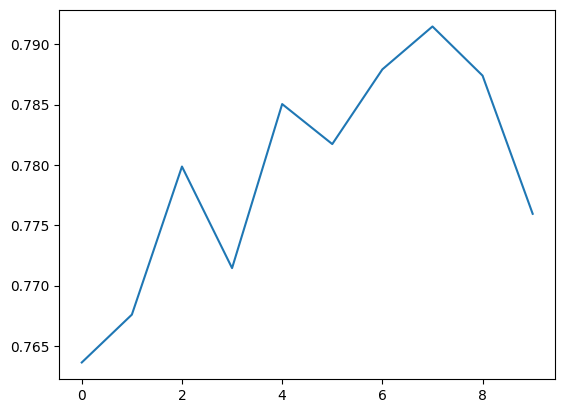

In [587]:
plt.plot(history['accs'])

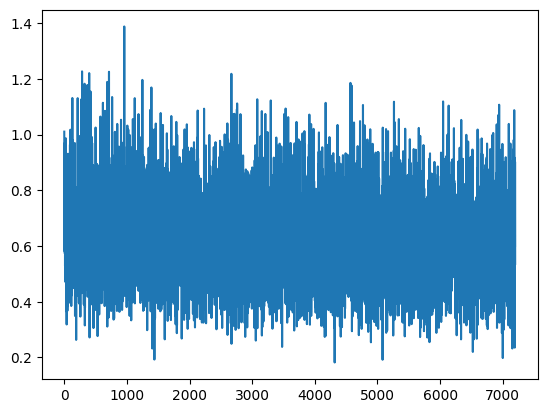

In [588]:
plt.plot(history['losses'])

In [589]:
single_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [590]:
dts = []
for data in single_test_dataloader:
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    if model.__class__.__name__ == 'ViT':
        inputs.unsqueeze_(axis=1)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = outputs.cpu().max(dim=1).indices

    dt = time.time() - start_time
    dts.append(dt)

dts = np.array(dts)[1:]
1 / dts[1:].mean(), 'Hz'

(411.61633976289335, 'Hz')

In [591]:
torch.save(model, 'pretained_vit.pt')

In [592]:
model_state_dict = model.state_dict()
torch.save(model_state_dict, 'pretained_vit_state_dict.pt')

# Transfer learning

**TODO**
Try if this improves performance

In [23]:
import copy
from pprint import pprint

import torch

# Models
# Encoder
G = torch.nn.Linear(1000, 100)
# CLassification head
C = torch.nn.Linear(100, 10)

D = torch.nn.Sequential(torch.nn.Linear(100, 1), torch.nn.Flatten(start_dim=0))
G_opt = torch.optim.Adam(G.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

dataset_size = 10000
# 1 batch of data
example_data = {
    "src_imgs": torch.randn(32, 1000),
    "target_imgs": torch.randn(32, 1000),
    "src_labels": torch.randint(0, 10, size=(32,)),
    "src_domain": torch.zeros(32),
    "target_domain": torch.zeros(32),
    "src_sample_idx": torch.randint(0, dataset_size, size=(32,)),
    "target_sample_idx": torch.randint(0, dataset_size, size=(32,)),
}


def get_data(keys):
    return {k: example_data[k] for k in keys}

In [24]:
from pytorch_adapt.hooks import MCDHook
from pytorch_adapt.layers import MultipleModels, SlicedWasserstein
from pytorch_adapt.utils import common_functions as c_f

In [50]:
# MCD needs 2 classifiers
C_ = MultipleModels(C, c_f.reinit(copy.deepcopy(C)))
C_opt_ = torch.optim.Adam(C_.parameters())
loss_fn = SlicedWasserstein(m=128)

hook = MCDHook(g_opts=[G_opt], c_opts=[C_opt_], discrepancy_loss_fn=loss_fn)

models = {"G": G, "C": C_}
data = get_data(["src_imgs", "target_imgs", "src_labels"])
_, losses = hook({**models, **data})
pprint(losses)

{'x_loss': {'src_c_loss0': 0.006591843441128731,
            'src_c_loss1': 2.502946615219116,
            'total': 1.254769206047058},
 'y_loss': {'discrepancy_loss': -0.4307219982147217,
            'src_c_loss0': 0.005981766618788242,
            'src_c_loss1': 2.2412302494049072,
            'total': 0.6054966449737549},
 'z_loss': {'discrepancy_loss': 0.2203170657157898,
            'total': 0.2203170657157898}}
